In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    precision_score,
    recall_score,
    confusion_matrix
)

from xgboost import XGBClassifier as xgb
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam


2025-06-02 16:08:33.503484: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from codecs import ignore_errors


bank_data = pd.read_csv("bank-full.csv", sep=';')

In [3]:
bank_data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

Let's examine the data types of our features 

In [4]:
bank_data.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

## Part 0: Basic preprocessing

Let's start by encoding our features and store the encoders 

In [5]:
categorical_cols = bank_data.select_dtypes(include=['object']).columns

In [6]:
# Dictionary to store the encoders for the different features
encoders = {}

In [7]:
for col in categorical_cols:
    encoder = LabelEncoder()
    bank_data[col] = encoder.fit_transform(bank_data[col])
    encoders[col] = encoder

In [8]:
bank_data.dtypes

age          int64
job          int64
marital      int64
education    int64
default      int64
balance      int64
housing      int64
loan         int64
contact      int64
day          int64
month        int64
duration     int64
campaign     int64
pdays        int64
previous     int64
poutcome     int64
y            int64
dtype: object

### Exploratory Data Analysis

Let's start by examining the target feature distribution

In [9]:
y = bank_data["y"]
X  = bank_data.drop("y", axis=1)

In [10]:
y

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: y, Length: 45211, dtype: int64

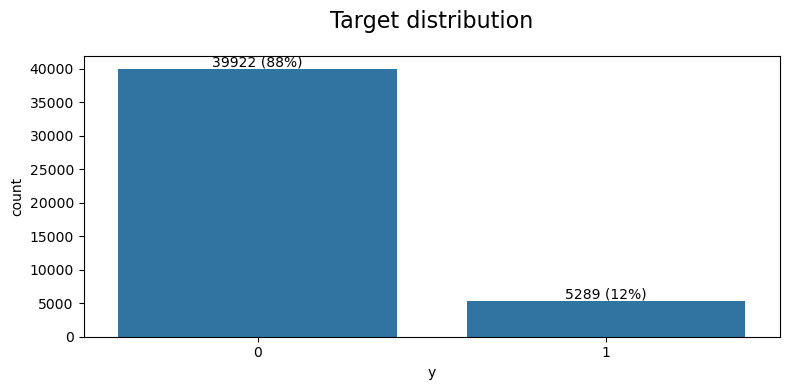

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.countplot(x=bank_data['y'], ax=ax)

abs_vals = bank_data['y'].value_counts()
rel_vals = bank_data['y'].value_counts(normalize=True) * 100
labels = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_vals, rel_vals)]

ax.bar_label(container=ax.containers[0], labels=labels)
ax.set_title('Target distribution', fontsize=16, pad=20)

plt.tight_layout();



To handle the imbalance in the dataset, we will combine both oversampling (using SMOTE) and undersampling to create a relatively balanced dataset.

It turns out that using both oversampling of the minority class and undersampling of the majority class yields better performance than using either technique alone. 

We will be using **Smoteenn** tool to combine both oversampling using SMOTE and undersampling using Edited Nearest Neighbor ENN

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
# new data distribution
print("Before balancing the labels: ------------------------------------------------------------------------")
print("y_train.value_counts() ", y_train.value_counts())
print("y_test.value_counts() ", y_test.value_counts())

Before balancing the labels: ------------------------------------------------------------------------
y_train.value_counts()  y
0    31937
1     4231
Name: count, dtype: int64
y_test.value_counts()  y
0    7985
1    1058
Name: count, dtype: int64


In [14]:
sme = SMOTEENN(random_state=42)

X_train, y_train = sme.fit_resample(X_train, y_train)

In [15]:
# new data distribution
print("After balancing the labels: ------------------------------------------------------------------------")
print("y_train.value_counts() ", y_train.value_counts())
print("y_test.value_counts() ", y_test.value_counts())

After balancing the labels: ------------------------------------------------------------------------
y_train.value_counts()  y
1    27961
0    22363
Name: count, dtype: int64
y_test.value_counts()  y
0    7985
1    1058
Name: count, dtype: int64


In [16]:
corr_matrix = bank_data.corr(numeric_only=True)

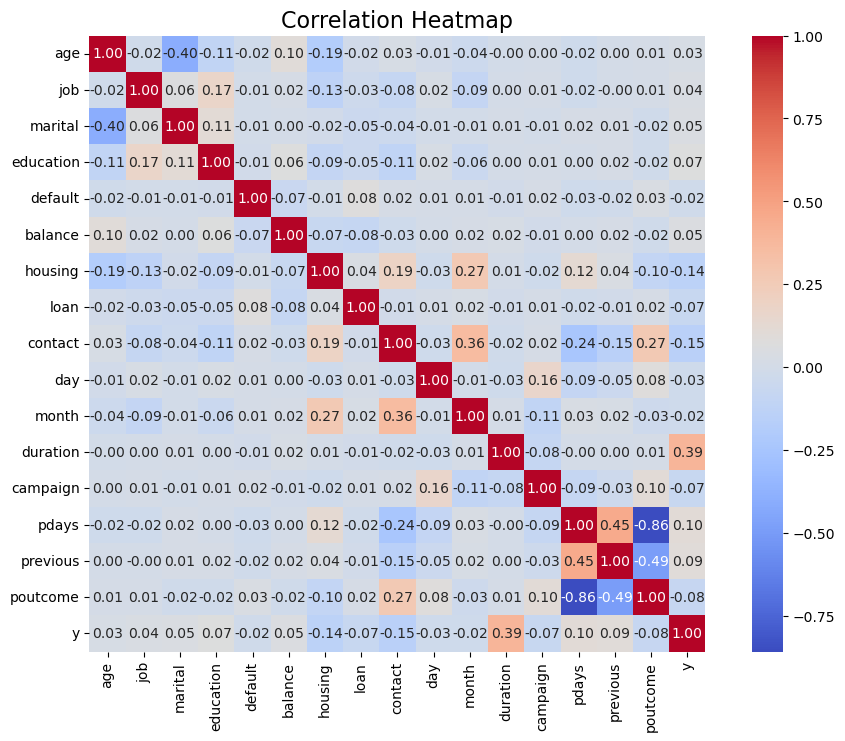

In [17]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

---------

## Part 1: Benchmarking several classification models

### 1. Naive Bayes Classifier

Since some of the data attributes consist of negative values, then we are gonna be using GaussianNB from sklearn library, which works well with our data attributes

In [18]:
nbc = GaussianNB()


#### Model Training

In [19]:
nbc.fit(X_train, y_train)

GaussianNB()

#### Model assessment

In [20]:
# 4. Predict on the test set
y_pred = nbc.predict(X_test)

In [21]:
accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.62      0.75      7985
           1       0.22      0.83      0.35      1058

    accuracy                           0.64      9043
   macro avg       0.59      0.73      0.55      9043
weighted avg       0.88      0.64      0.71      9043



In [1]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred):.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes')
plt.legend()
plt.show()

NameError: name 'roc_curve' is not defined

#### Conclusion:
The performance of the Naive Bayes classifier is suboptimal because it is highly sensitive to the imbalance in the target feature distribution. One reason for its poor performance on this dataset is that the majority class dominates the classification, making it difficult for the model to correctly identify instances of the minority class.

### 2. Logistic Regression Implementation

We'll implement logistic regression with proper hyperparameter tuning and comprehensive evaluation.

In [23]:
log_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(max_iter=1000, random_state=42))
])

param_grid = {
    'logistic__C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'logistic__penalty': ['l1', 'l2'],       # Regularization type
    'logistic__solver': ['liblinear'],        # Works well with both l1 and l2
    'logistic__class_weight': ['balanced', None]  # Handle class imbalance
}

grid_search = GridSearchCV(
    log_reg_pipeline, 
    param_grid, 
    cv=5, 
    scoring='f1', 
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

best_logistic = grid_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'logistic__C': 0.01, 'logistic__class_weight': None, 'logistic__penalty': 'l2', 'logistic__solver': 'liblinear'}
Best cross-validation score: 0.9089


In [24]:
y_pred_logistic = best_logistic.predict(X_test)
y_prob_logistic = best_logistic.predict_proba(X_test)[:, 1]

print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob_logistic):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logistic))

ROC AUC Score: 0.8638

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.80      0.87      7985
           1       0.33      0.78      0.47      1058

    accuracy                           0.79      9043
   macro avg       0.65      0.79      0.67      9043
weighted avg       0.89      0.79      0.82      9043



### Visualizing Logistic Regression Results

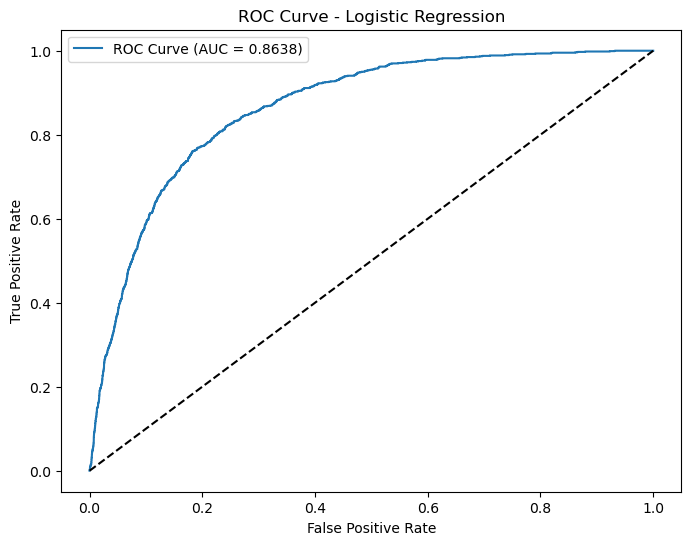

In [25]:
fpr, tpr, _ = roc_curve(y_test, y_prob_logistic)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob_logistic):.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()

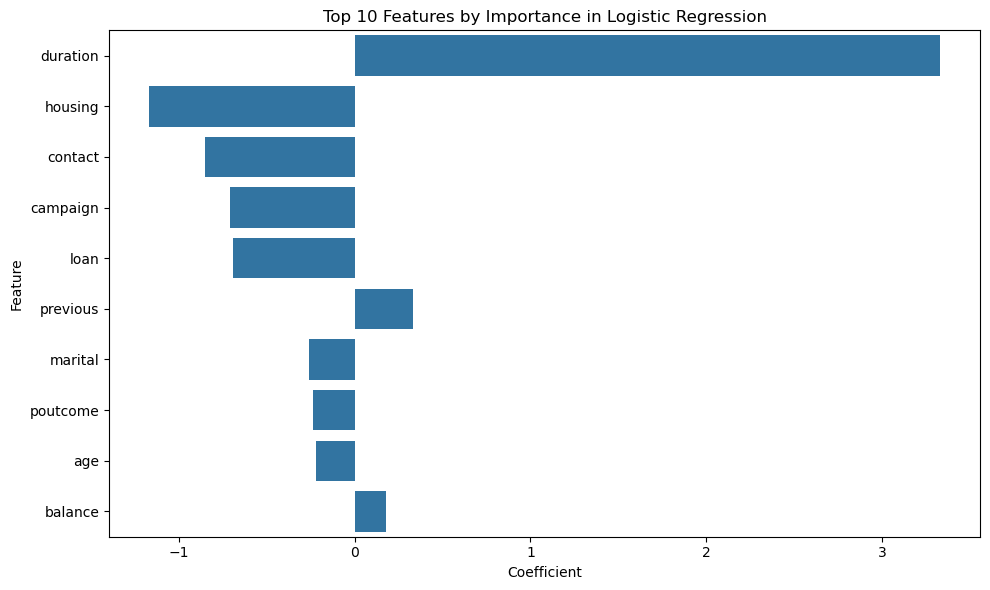

In [26]:
# Feature importance analysis for interpretability
coefficients = best_logistic.named_steps['logistic'].coef_[0]
feature_names = X.columns
importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
importance = importance.sort_values('Coefficient', key=abs, ascending=False)

# Plot top 10 features by importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=importance.head(10))
plt.title('Top 10 Features by Importance in Logistic Regression')
plt.tight_layout()
plt.show()

### 3. Decision Tree Classifier

We'll implement Decision Tree classifier with proper hyperparameter tuning and comprehensive evaluation.

#### Model selection and fitting

In [27]:
dtc = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],  
    'max_depth': [None, 5, 10, 20, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=dtc,
    param_grid=param_grid,
    cv=5,             
    scoring='accuracy',
    n_jobs=-1,         
    verbose=1
)

grid_search.fit(X_train, y_train) 

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

best_dtc = grid_search.best_estimator_

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Cross-Validation Score: 0.9358161279979024


#### Model assessment

In [28]:
y_pred_dtc = best_dtc.predict(X_test)
y_prob_dtc = best_dtc.predict_proba(X_test)[:, 1]

print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob_dtc):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dtc))

ROC AUC Score: 0.7941

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.84      0.90      7985
           1       0.38      0.74      0.50      1058

    accuracy                           0.83      9043
   macro avg       0.67      0.79      0.70      9043
weighted avg       0.89      0.83      0.85      9043



### Visualizing Decision Tree Results

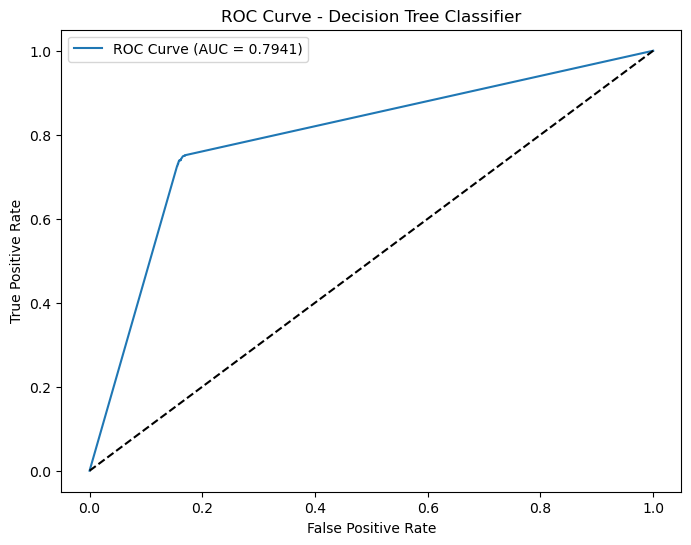

In [29]:
fpr, tpr, _ = roc_curve(y_test, y_prob_dtc)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob_dtc):.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree Classifier')
plt.legend()
plt.show()

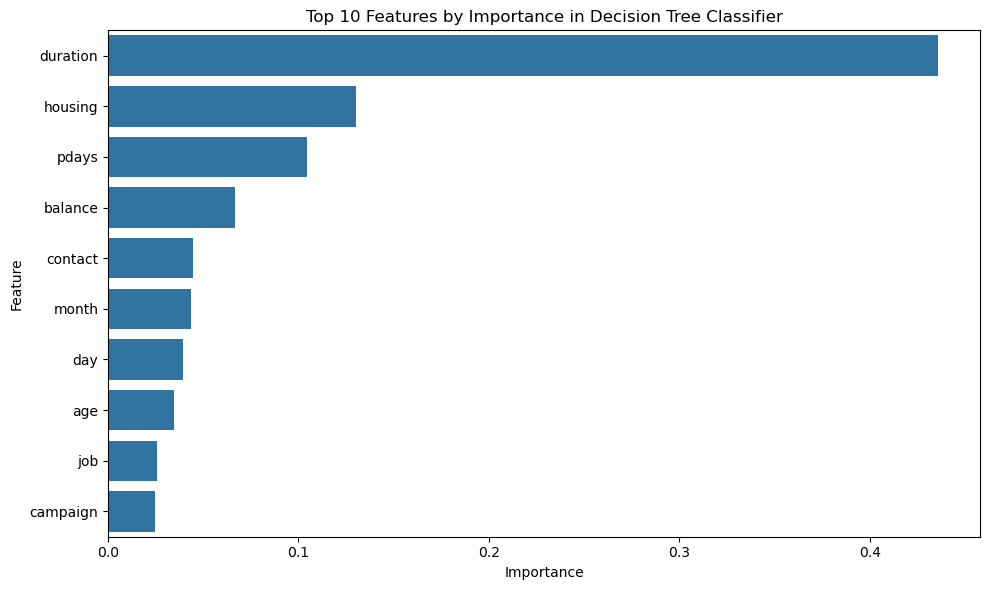

In [30]:
# Get feature importances from the trained Decision Tree model
importances_dt = best_dtc.feature_importances_  # No need for 'named_steps' here
feature_names = X.columns

# Create a DataFrame with feature names and their importances
importance_dt = pd.DataFrame({'Feature': feature_names, 'Importance': importances_dt})
importance_dt = importance_dt.sort_values('Importance', ascending=False)

# Plot top 10 features by importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_dt.head(10))
plt.title('Top 10 Features by Importance in Decision Tree Classifier')
plt.tight_layout()
plt.show()


#### Conclusion:
The performance of the Decision Tree classifier remains limited even after balancing, as it still struggles to accurately identify clients who will subscribe. It tends to over-predict positive responses, leading to many false positives.

### 4- Artificial neural network


#### Scaling the data


In [31]:
# Standardize features (important for ANN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Building the model


In [32]:
ann = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Use 'softmax' and adjust units for multi-class classification
])

/home/aya/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Compiling the model


In [33]:
ann.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class
              metrics=['f1_score'])

#### Training the Model


In [34]:
history = ann.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 2s 691us/step - f1_score: 0.6147 - loss: 0.3337 - val_f1_score: 1.0000 - val_loss: 0.1640
Epoch 2/50
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 1s 539us/step - f1_score: 0.6135 - loss: 0.2165 - val_f1_score: 1.0000 - val_loss: 0.2066
Epoch 3/50
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 1s 526us/step - f1_score: 0.6136 - loss: 0.2079 - val_f1_score: 1.0000 - val_loss: 0.1908
Epoch 4/50
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 1s 535us/step - f1_score: 0.6126 - loss: 0.2038 - val_f1_score: 1.0000 - val_loss: 0.1436
Epoch 5/50
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 1s 601us/step - f1_score: 0.6135 - loss: 0.1975 - val_f1_score: 1.0000 - val_loss: 0.1786
Epoch 6/50
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 1s 639us/step - f1_score: 0.6179 - loss: 0.1953 - val_f1_score: 1.0000 - val_loss: 0.1484
Epoch 7/50
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 1s 623us/step - f1_score: 0.6152 - loss: 0.1978 - val_f1_score: 1.0000 - val_loss: 0.1783
Epoch 8/50
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 1s 590us/step - f1_score: 0.6161 -

#### the loss function and accuracy


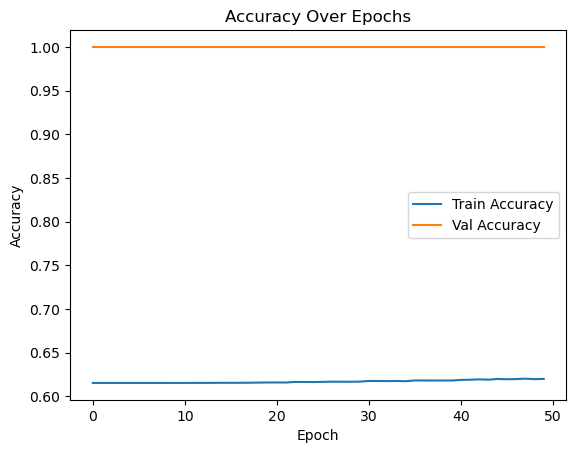

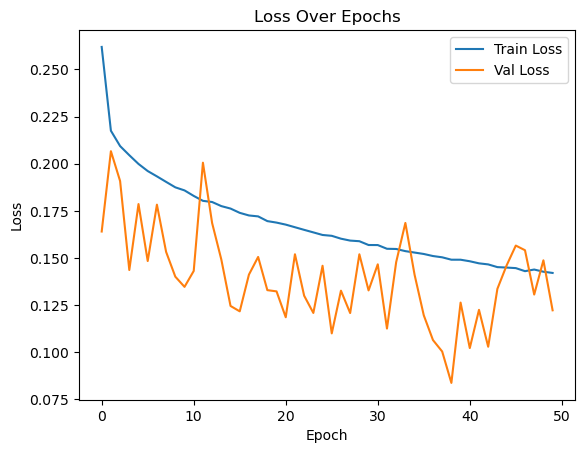

In [35]:
# Accuracy plot
plt.plot(history.history['f1_score'], label='Train Accuracy')
plt.plot(history.history['val_f1_score'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


#### Model Evaluation


In [36]:
# 4. Predict on the test set
y_prob_ann = ann.predict(X_test_scaled)

283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step


##### best treshhold for classification based on F1 score


In [37]:
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_test, (y_prob_ann > t).astype(int)) for t in thresholds]
best_thresh_ann = thresholds[np.argmax(f1_scores)]

print(f"Optimal Threshold for ANN: {best_thresh_ann:.2f}")

Optimal Threshold for ANN: 0.73


In [38]:
y_pred_ann = (y_prob_ann > best_thresh_ann).astype(int)

In [39]:
print("Accuracy:", accuracy_score(y_test, y_pred_ann))
print("\nClassification Report:\n", classification_report(y_test, y_pred_ann))

Accuracy: 0.8740462235983634

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      7985
           1       0.47      0.69      0.56      1058

    accuracy                           0.87      9043
   macro avg       0.72      0.79      0.74      9043
weighted avg       0.90      0.87      0.88      9043



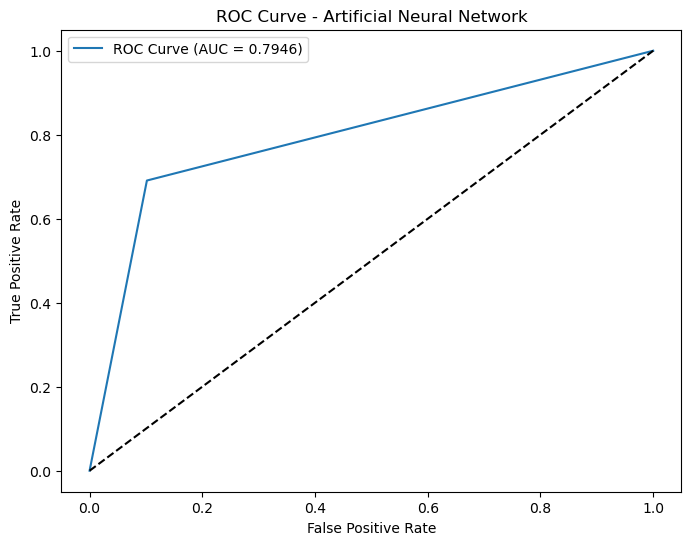

In [64]:
fpr, tpr, _ = roc_curve(y_test, y_pred_ann)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_ann):.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Artificial Neural Network')
plt.legend()
plt.show()


### 5. SVM


implement an SVM model on the train data, try to get the best params and assess the performance of the model


initialize the model, we'll search for the best params later


In [41]:
svm_model = LinearSVC()  

fit the model on the train data


In [42]:
svm_model.fit(X_train, y_train)

LinearSVC()

we use the trained model to predict new instances and see the result


In [43]:
y_pred = svm_model.predict(X_test)

In [44]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("###############################################################")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("###############################################################")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7891186553135021
Precision: 0.33080908728577124
Recall: 0.7844990548204159
F1 Score: 0.4653770675637791
###############################################################
Confusion Matrix:
 [[6306 1679]
 [ 228  830]]
###############################################################

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.79      0.87      7985
           1       0.33      0.78      0.47      1058

    accuracy                           0.79      9043
   macro avg       0.65      0.79      0.67      9043
weighted avg       0.89      0.79      0.82      9043



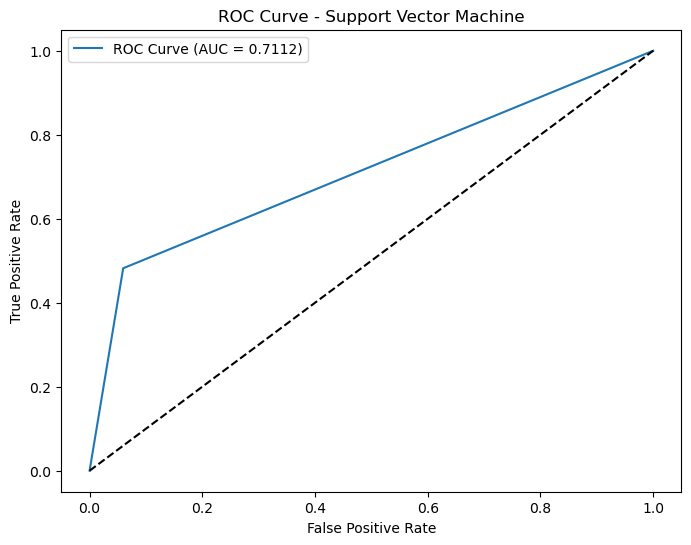

In [66]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred):.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Support Vector Machine')
plt.legend()
plt.show()

#### Conclusion:
Support Vector Machines (SVM) tend to perform poorly on our dataset. This may is caused by several factors:
1. Bias Towards the Majority Class
SVM tries to maximize the margin without considering the class distribution. Since there are far more samples from the majority class, the optimal hyperplane skews towards the minority class, leading to poor recall for the minority class.
2. Support Vectors are Imbalanced:
The algorithm selects support vectors mostly from the majority class. As a result, the influence of the minority class is minimized, and it may be entirely misclassified.
3. Margin Calculation is Skewed:
The calculation of the maximum margin is heavily influenced by the dominant class, causing the decision boundary to be far from where it ideally should be.


### 6. Random Forest
We'll implement Random Forest approach with proper hyperparameter tuning and comprehensive evaluation.

#### Model selection and fitting

```python
rfc = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],          
    'criterion': ['gini', 'entropy'],        
    'max_depth': [None, 10, 20, 30],         
    'min_samples_split': [2, 5, 10],         
    'min_samples_leaf': [1, 2, 4],           
    'max_features': ['auto', 'sqrt', 'log2'] 
}

grid_search = GridSearchCV(
    estimator=rfc,
    param_grid=param_grid,
    cv=5,                    
    scoring='accuracy',
    n_jobs=-1,               
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)```

In [46]:
best_rfc = RandomForestClassifier(
    criterion= 'entropy', max_depth= None, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 200,random_state=42) 

In [47]:
best_rfc.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=200, random_state=42)

#### Model assessment

In [48]:
y_pred_rfc = best_rfc.predict(X_test)
y_prob_rfc = best_rfc.predict_proba(X_test)[:, 1]

print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob_rfc):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rfc))

ROC AUC Score: 0.9104

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      7985
           1       0.43      0.81      0.56      1058

    accuracy                           0.85      9043
   macro avg       0.70      0.83      0.73      9043
weighted avg       0.91      0.85      0.87      9043



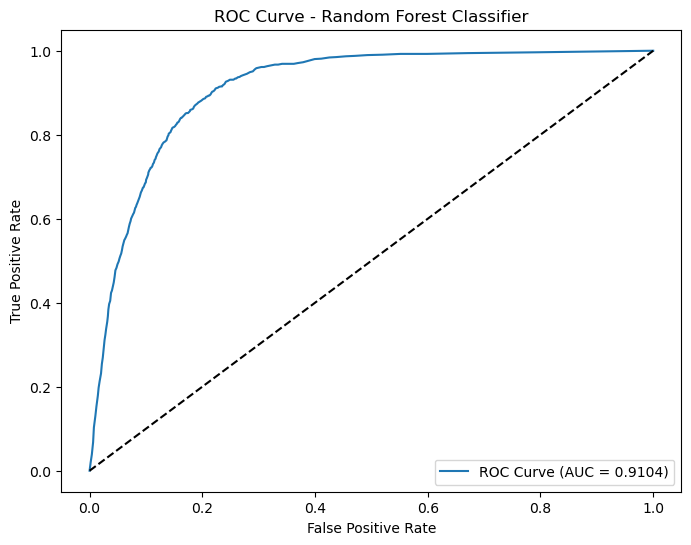

In [69]:
fpr, tpr, _ = roc_curve(y_test, y_prob_rfc)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob_rfc):.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Classifier')
plt.legend()
plt.show()


#### Conclusion

The Random Forest model performs well. It finds most people who are likely to subscribe and does a much better job than the decision tree. However, it still guesses "yes" too often, which leads to some false alarms.


### 7. XGBOOST classifier
We'll implement Boosting approach with proper hyperparameter tuning and comprehensive evaluation.

#### Model selection and fitting

```python
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': randint(0, 6),
    'min_child_weight': randint(1, 10)
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,  
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation F1 Score:", random_search.best_score_)

best_xgb = random_search.best_estimator_
```


In [50]:
best_xgb = xgb(random_state=42, use_label_encoder=False, eval_metric='logloss',
                        colsample_bytree= 0.687505687829228, gamma= 0, learning_rate= 0.13115085131741225, 
                        max_depth= 8, min_child_weight= 1, n_estimators= 235, subsample= 0.9849789179768444,
                        scale_pos_weight= 5)

In [51]:
best_xgb.fit(X_train, y_train)

/home/aya/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:11:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.687505687829228, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.13115085131741225,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=235, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

#### Model assessment

In [52]:
y_pred_xgb = best_xgb.predict(X_test)
y_prob_xgb = best_xgb.predict_proba(X_test)[:, 1]

print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob_xgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

ROC AUC Score: 0.9143

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.90      7985
           1       0.42      0.85      0.56      1058

    accuracy                           0.84      9043
   macro avg       0.70      0.84      0.73      9043
weighted avg       0.91      0.84      0.86      9043



### Visualizing Decision Tree Results

In [73]:
roc = roc_auc_score(y_test, y_prob_xgb)
roc

0.9143073082445464

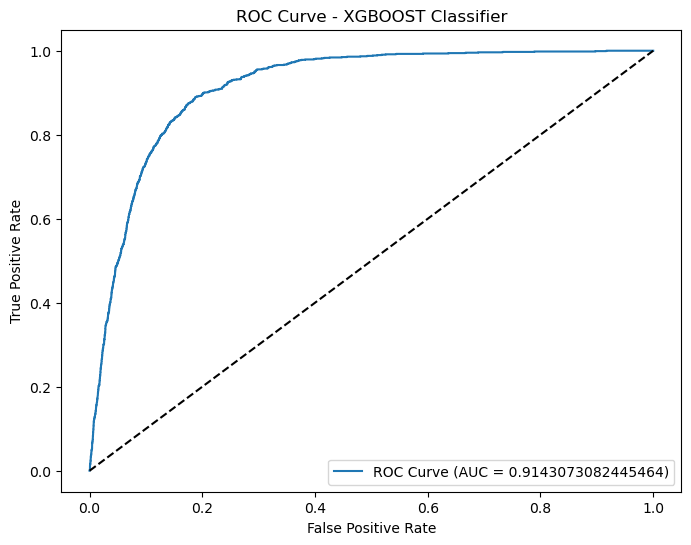

In [74]:
fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBOOST Classifier')
plt.legend()
plt.show()

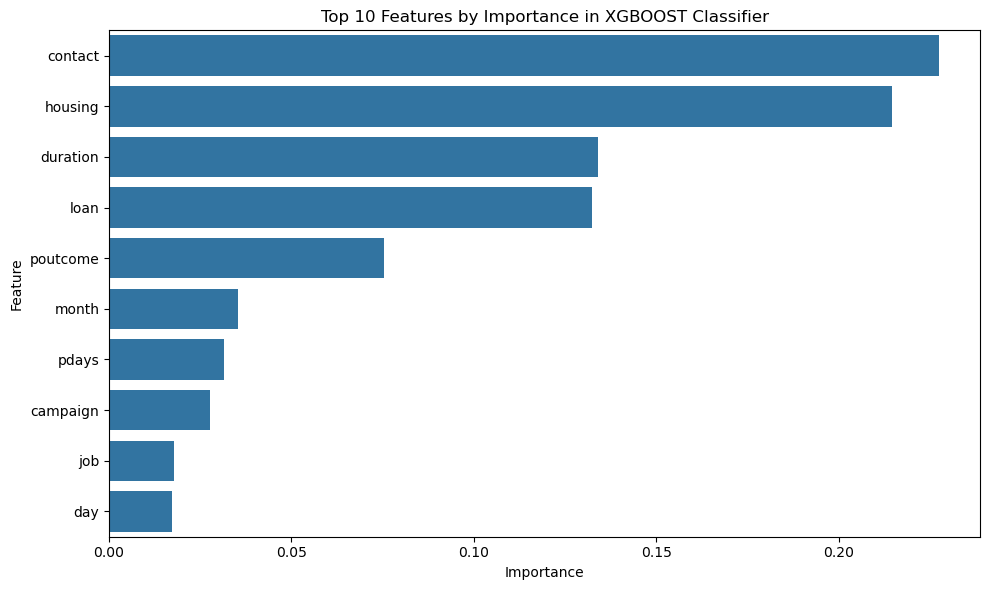

In [54]:
importances_xgb = best_xgb.feature_importances_ 
feature_names = X.columns

importance_xgb = pd.DataFrame({'Feature': feature_names, 'Importance': importances_xgb})
importance_xgb = importance_xgb.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_xgb.head(10))
plt.title('Top 10 Features by Importance in XGBOOST Classifier')
plt.tight_layout()
plt.show()


#### Conclusion
The XGBoost model performed well overall. It was especially good at correctly identifying customers who won’t subscribe (label 0), and it did a decent job identifying those who will (label 1).

Although it's not perfect, it managed to find a good balance — catching many of the potential subscribers without too many false positives.

Comparing to other models it is the best until now.

--------

## Part 2: Model Comparison


Model Comparison:
Logistic Regression: Accuracy = 0.7930, F1 Score = 0.4670
Decision Tree: Accuracy = 0.8267, F1 Score = 0.5005
Random Forest: Accuracy = 0.8505, F1 Score = 0.5579
XGBoost: Accuracy = 0.8425, F1 Score = 0.5569
Naive Bayes: Accuracy = 0.6428, F1 Score = 0.3530


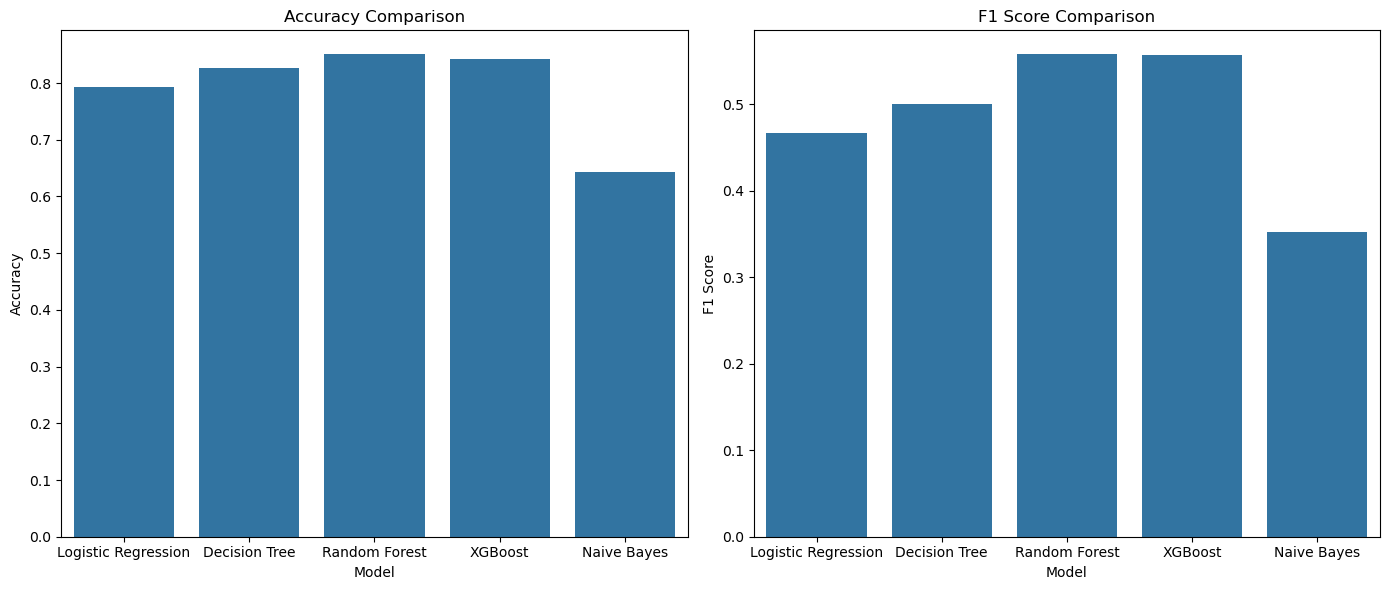

In [55]:
print("\nModel Comparison:")
models = {
    'Logistic Regression': best_logistic,
    'Decision Tree': best_dtc,
    'Random Forest': best_rfc,
    'XGBoost': best_xgb,
    'Naive Bayes': nbc
}

results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append({'Model': name, 'Accuracy': acc, 'F1 Score': f1})
    print(f"{name}: Accuracy = {acc:.4f}, F1 Score = {f1:.4f}")

results_df = pd.DataFrame(results)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df, ax=ax[0])
ax[0].set_title('Accuracy Comparison')
sns.barplot(x='Model', y='F1 Score', data=results_df, ax=ax[1])
ax[1].set_title('F1 Score Comparison')
plt.tight_layout()
plt.show()

## Model Improvements

We'll address four key improvement areas:
1. Decision threshold adjustment to optimize precision
2. i am not sure about this but the feature 'duration' may introduce data leakage since :
    "A Data-Driven Approach to Predict the Success of Bank Telemarketing" (2014)
    Authors: Moro, S., Cortez, P., & Rita, P.
    Journal: Decision Support Systems

    Key findings on duration:

    "The duration is an extremely important attribute... However, this attribute should be discarded if the goal is to build a predictive model for a real telemarketing campaign, since the duration is not known before a call is performed."
    i didn't yet remove it while modeling we should discuss this point.
3- ROI Analysis

    A comprehensive business analysis section demonstrates:

      - Calculation of marketing campaign costs
      - Estimation of profits from successful term deposits
      - Optimization of probability threshold for maximum ROI
      - Comparison between model-based targeting and random targeting
      - Sensitivity analysis with different business assumptions


### 1. Feature Engineering

The 'duration' feature is highly predictive but represents a form of data leakage since it's only known after a call is made. We'll create alternative features and also try a model without this feature.

In [56]:
X_train_fe = X_train.copy()
X_test_fe = X_test.copy()

X_train_fe['age_balance'] = X_train_fe['age'] * X_train_fe['balance'] / 10000  # Normalized interaction
X_test_fe['age_balance'] = X_test_fe['age'] * X_test_fe['balance'] / 10000

# 2. Create a previous campaign engagement score
X_train_fe['previous_engagement'] = X_train_fe['previous'] * (X_train_fe['poutcome'] == 1).astype(int)
X_test_fe['previous_engagement'] = X_test_fe['previous'] * (X_test_fe['poutcome'] == 1).astype(int)

# 3. Create contact recency buckets for pdays (more interpretable than raw values)
def categorize_pdays(pdays):
    if pdays == -1: 
        return 0
    elif pdays < 30:
        return 1
    elif pdays < 90:
        return 2
    else: 
        return 3

X_train_fe['pdays_cat'] = X_train_fe['pdays'].apply(categorize_pdays)
X_test_fe['pdays_cat'] = X_test_fe['pdays'].apply(categorize_pdays)


X_train_no_duration = X_train_fe.drop('duration', axis=1)
X_test_no_duration = X_test_fe.drop('duration', axis=1)

print(f"New features created: {list(set(X_train_fe.columns) - set(X_train.columns))}")
print(f"Shape with new features: {X_train_fe.shape}")
print(f"Shape without duration: {X_train_no_duration.shape}")

New features created: ['age_balance', 'previous_engagement', 'pdays_cat']
Shape with new features: (50324, 19)
Shape without duration: (50324, 18)


### 2. Cost-Sensitive Learning

In marketing campaigns, false positives (predicting someone will subscribe when they don't) cost marketing resources. We'll implement a cost matrix and class weights to address this.

In [57]:
class_weights = {0:1, 1: 3}  # Start by giving more emphasis to finding true positives

log_reg_cost_sensitive = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', best_logistic)
])

log_reg_cost_sensitive.fit(X_train_fe, y_train)

y_prob_cost_sensitive = log_reg_cost_sensitive.predict_proba(X_test_fe)[:, 1]
y_pred_default = (y_prob_cost_sensitive >= 0.75).astype(int)

print("\nCost-Sensitive Model Results (threshold=0.8):")
print(classification_report(y_test, y_pred_default))


Cost-Sensitive Model Results (threshold=0.8):
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      7985
           1       0.44      0.65      0.52      1058

    accuracy                           0.86      9043
   macro avg       0.69      0.77      0.72      9043
weighted avg       0.89      0.86      0.87      9043



In [58]:

# class_weights = {0:1, 1: 3}

# # 2. Train model with class weights and without duration feature
# log_reg_cost_sensitive = Pipeline([
#     ('scaler', StandardScaler()),
#     ('logistic', LogisticRegression(max_iter=1000, random_state=42, 
#                                    class_weight=class_weights,
#                                    C=10, penalty='l1', solver='liblinear'))
# ])

# # Train on the dataset without duration to avoid leakage
# log_reg_cost_sensitive.fit(X_train_no_duration, y_train)

# y_prob_cost_sensitive = log_reg_cost_sensitive.predict_proba(X_test_no_duration)[:, 1]
# y_pred_default = (y_prob_cost_sensitive >= 0.8).astype(int)

# print("\nCost-Sensitive Model Results (threshold=0.8):")
# print(classification_report(y_test, y_pred_default))

### 3. Feature Importance in the Optimized Model

## ROI Analysis of Marketing Campaign

In this section, we'll analyze the Return on Investment (ROI) for the term deposit marketing campaign. We'll use industry standard figures:

- Customer Acquisition Cost (CAC): €5-15 per prospect contacted
- Term Deposit Value: €10,000 average
- Bank profit margin: 1-3% spread (€100-€400 per deposit per year)

We'll calculate ROI based on our model's predictions vs randomly targeting customers.

In [59]:

avg_deposit_amount = 10000  # Average term deposit in EUR
cost_per_contact = 10       # Cost per marketing contact in EUR
profit_margin = 0.02        # 2% profit margin (conservative estimate)
deposit_duration_years = 1  # Assuming 1-year term deposits

# Calculate profit per successful deposit
profit_per_deposit = avg_deposit_amount * profit_margin * deposit_duration_years

print(f"Marketing cost per contact: €{cost_per_contact}")
print(f"Profit per successful term deposit: €{profit_per_deposit}")

y_prob = log_reg_cost_sensitive.predict_proba(X_test_fe)[:, 1]

Marketing cost per contact: €10
Profit per successful term deposit: €200.0


### Optimizing Decision Threshold for Maximum ROI

We'll analyze different probability thresholds to find the one that maximizes ROI.

In [60]:
# Test different thresholds for ROI optimization
thresholds = np.arange(0.1, 0.95, 0.05)
results = []

for threshold in thresholds:
    y_pred = (y_prob >= threshold).astype(int)
    
    true_pos = ((y_pred == 1) & (y_test == 1)).sum()
    false_pos = ((y_pred == 1) & (y_test == 0)).sum()
    total_contacted = (y_pred == 1).sum()
    
    marketing_cost = total_contacted * cost_per_contact
    revenue = true_pos * profit_per_deposit
    roi = (revenue - marketing_cost) / marketing_cost if marketing_cost > 0 else 0
    net_profit = revenue - marketing_cost
    conversion_rate = true_pos / total_contacted if total_contacted > 0 else 0
    
    results.append({
        'threshold': threshold,
        'contacts': total_contacted,
        'true_positives': true_pos,
        'false_positives': false_pos,
        'marketing_cost': marketing_cost,
        'revenue': revenue,
        'net_profit': net_profit,
        'roi': roi,
        'conversion_rate': conversion_rate
    })

roi_df = pd.DataFrame(results)
roi_df['roi_percentage'] = roi_df['roi'] * 100

roi_df[['threshold', 'contacts', 'true_positives', 'conversion_rate', 'marketing_cost', 
        'revenue', 'net_profit', 'roi_percentage']].round(2)

,threshold,contacts,true_positives,conversion_rate,marketing_cost,revenue,net_profit,roi_percentage
0,0.10,5073,1017,0.20,50730,203400.0,152670.0,300.95
1,0.15,4491,995,0.22,44910,199000.0,154090.0,343.11
2,0.20,4091,978,0.24,40910,195600.0,154690.0,378.12
3,0.25,3708,958,0.26,37080,191600.0,154520.0,416.72
4,0.30,3376,929,0.28,33760,185800.0,152040.0,450.36
5,0.35,3084,911,0.30,30840,182200.0,151360.0,490.79
6,0.40,2808,886,0.32,28080,177200.0,149120.0,531.05
7,0.45,2593,857,0.33,25930,171400.0,145470.0,561.01
8,0.50,2374,830,0.35,23740,166000.0,142260.0,599.24
9,0.55,2185,804,0.37,21850,160800.0,138950.0,635.93


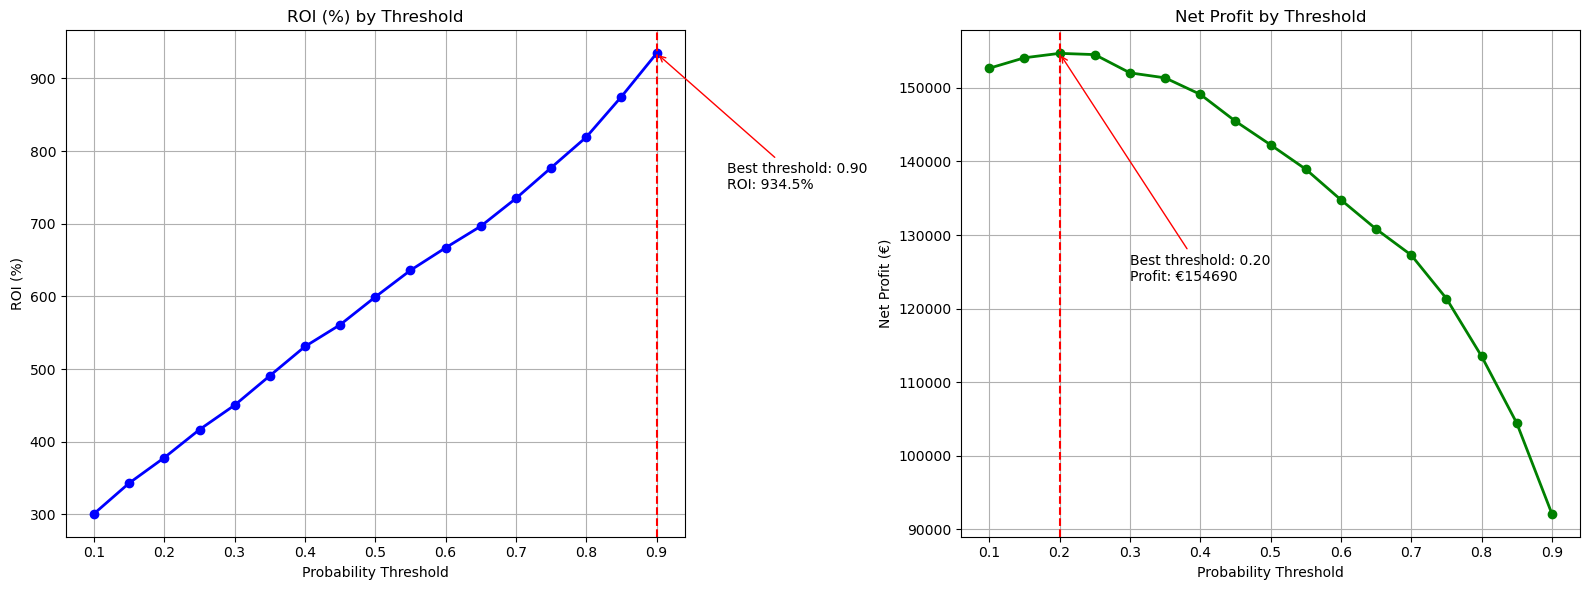

In [61]:
# Visualize ROI vs threshold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ROI percentage by threshold
ax1.plot(roi_df['threshold'], roi_df['roi_percentage'], 'bo-', linewidth=2)
ax1.set_title('ROI (%) by Threshold')
ax1.set_xlabel('Probability Threshold')
ax1.set_ylabel('ROI (%)')
ax1.grid(True)

# Mark the best threshold
best_threshold_idx = roi_df['roi_percentage'].idxmax()
best_threshold = roi_df.loc[best_threshold_idx, 'threshold']
best_roi = roi_df.loc[best_threshold_idx, 'roi_percentage']
ax1.axvline(best_threshold, color='r', linestyle='--')
ax1.annotate(f'Best threshold: {best_threshold:.2f}\nROI: {best_roi:.1f}%', 
             xy=(best_threshold, best_roi),
             xytext=(best_threshold+0.1, best_roi*0.8),
             arrowprops=dict(arrowstyle="->", color='red'))

# Net profit by threshold
ax2.plot(roi_df['threshold'], roi_df['net_profit'], 'go-', linewidth=2)
ax2.set_title('Net Profit by Threshold')
ax2.set_xlabel('Probability Threshold')
ax2.set_ylabel('Net Profit (€)')
ax2.grid(True)

# Mark the best threshold for profit
best_profit_idx = roi_df['net_profit'].idxmax()
best_profit_threshold = roi_df.loc[best_profit_idx, 'threshold']
best_profit = roi_df.loc[best_profit_idx, 'net_profit']
ax2.axvline(best_profit_threshold, color='r', linestyle='--')
ax2.annotate(f'Best threshold: {best_profit_threshold:.2f}\nProfit: €{best_profit:.0f}', 
             xy=(best_profit_threshold, best_profit),
             xytext=(best_profit_threshold+0.1, best_profit*0.8),
             arrowprops=dict(arrowstyle="->", color='red'))

plt.tight_layout()
plt.show()

### Comparing Model-Based vs Random Marketing Approach

Let's compare our model's ROI with a random approach (contacting customers without using the model).

In [62]:
optimal_threshold = roi_df.loc[roi_df['net_profit'].idxmax(), 'threshold']
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)

true_pos_optimal = ((y_pred_optimal == 1) & (y_test == 1)).sum()
total_contacted_optimal = (y_pred_optimal == 1).sum()
conversion_rate_optimal = true_pos_optimal / total_contacted_optimal if total_contacted_optimal > 0 else 0

random_conversion_rate = y_test.mean()

# For fair comparison, assume the same budget (contacting same number of people)
budget = total_contacted_optimal * cost_per_contact
random_contacts = int(budget / cost_per_contact)  # Same budget
random_conversions = int(random_contacts * random_conversion_rate)

# Calculate financials
model_cost = total_contacted_optimal * cost_per_contact
model_revenue = true_pos_optimal * profit_per_deposit
model_profit = model_revenue - model_cost
model_roi = (model_revenue / model_cost - 1) * 100

random_cost = random_contacts * cost_per_contact
random_revenue = random_conversions * profit_per_deposit
random_profit = random_revenue - random_cost
random_roi = (random_revenue / random_cost - 1) * 100

# Create comparison table
comparison = pd.DataFrame({
    'Approach': ['Random Targeting', 'ML Model Targeting'],
    'People Contacted': [random_contacts, total_contacted_optimal],
    'Marketing Cost (€)': [random_cost, model_cost],
    'Subscriptions': [random_conversions, true_pos_optimal],
    'Conversion Rate (%)': [random_conversion_rate*100, conversion_rate_optimal*100],
    'Revenue (€)': [random_revenue, model_revenue],
    'Net Profit (€)': [random_profit, model_profit],
    'ROI (%)': [random_roi, model_roi],
    'Improvement Factor': [1.0, model_profit/random_profit if random_profit > 0 else float('inf')]
})

# Display formatted comparison
comparison.set_index('Approach').round(2)

,People Contacted,Marketing Cost (€),Subscriptions,Conversion Rate (%),Revenue (€),Net Profit (€),ROI (%),Improvement Factor
Approach,,,,,,,,
Random Targeting,4091,40910,478,11.70,95600.0,54690.0,133.68,1.00
ML Model Targeting,4091,40910,978,23.91,195600.0,154690.0,378.12,2.83


/home/aya/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:11:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Ensemble Model Results:
ROC AUC Score: 0.9086

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      7985
           1       0.41      0.84      0.55      1058

    accuracy                           0.84      9043
   macro avg       0.69      0.84      0.73      9043
weighted avg       0.91      0.84      0.86      9043



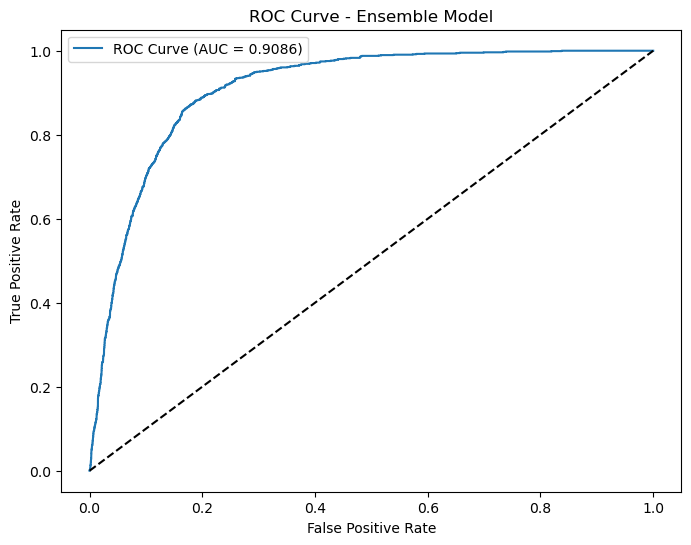

In [63]:
from sklearn.ensemble import VotingClassifier


ensemble_models = [
    ('xgb', best_xgb), 
    ('rf', best_rfc),   
    ('lr', best_logistic) 
]


ensemble = VotingClassifier(
    estimators=ensemble_models,
    voting='soft',  
    weights=[1, 1, 1]  # Give higher weight to XGBoost, then LR, then RF
)

ensemble.fit(X_train, y_train)

y_prob_ensemble = ensemble.predict_proba(X_test)[:, 1]
y_pred_ensemble = ensemble.predict(X_test)

print("Ensemble Model Results:")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob_ensemble):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ensemble))

fpr, tpr, _ = roc_curve(y_test, y_prob_ensemble)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob_ensemble):.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Ensemble Model')
plt.legend()
plt.show()



